Analysis Agenda(先檢閱資料猜測資料意涵)
- 題目猜測 : 美國各州的各黨派(某些)議員針對15項議題或是政策是否支持與反對或是中立
- 分析結構 : 
    - 基本檢視(了解資料) : '此份資料'有幾個議員、有幾個黨派、各黨派有幾個人、有幾個州、一個州有幾個議員、各州議員是否為皆為同一黨派(比例)、是否有遺失值
    - 進階檢視 : 各議題支持度、有無黨派對某項議題支持度高、判斷哪些議員的支持項目選擇相似(是否與黨派有關)
    - GIS分布 : 一個州有幾個議員、顯示議員資訊、顯示黨派顏色、顯示該州支持議題個數、反對議題個數、標註並儲存有相同黨派的州、分群結果
    - 外部資源 : 貼上議員性別、年齡，分析各項議題是否與議員性別、年齡有正相關；對照目前各州R、D、I關係


## Import packages 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import geopandas as gpd
import folium
from folium.features import DivIcon

In [7]:
# read csv
df = pd.read_csv('C:\\Users\\專案企劃科專用\\Desktop\\python\\party\\dev\\data\\TEST.csv')
df.head()

,name,party,state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Base analysis

In [8]:
df.shape

(100, 18)

In [9]:
# 是否有遺失值 : 皆無遺失值
df.isnull().mean()

name     0.0
party    0.0
state    0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
dtype: float64

In [10]:
# 有幾個議員 : 100個議員無重複
len(df['name'].drop_duplicates())

100

In [11]:
# 有幾個黨派 : 3
len(df['party'].drop_duplicates())

3

In [12]:
# 有幾個州 : 50
len(df['state'].drop_duplicates())

50

In [13]:
# 一個州有幾個議員 : 此份資料皆為2個
temp = pd.DataFrame(df['state'].value_counts())
temp.reset_index(inplace=True)
temp['count'].value_counts()

count
2    50
Name: count, dtype: int64

In [14]:
# 檢視欄位1~15種類 : 發現不是只有0、1
counts = df.iloc[:, range(3,18)].apply(lambda x: x.value_counts(normalize=True))
counts

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.0,0.66,0.42,0.46,0.05,0.45,0.58,0.45,0.01,0.46,0.43,0.58,0.51,0.48,0.53,0.62
0.5,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.05,0.02,0.02,0.02,0.02,0.02
1.0,0.31,0.57,0.53,0.94,0.54,0.41,0.54,0.98,0.51,0.52,0.40,0.47,0.50,0.45,0.36


In [15]:
# 各黨派有幾個人
df['party'].value_counts()

party
R    54
D    44
I     2
Name: count, dtype: int64

In [16]:
# 各州議員是否為皆為同一黨派 : 有7成(35個)的州其議員為相同黨派，3成(15個)為不同黨派
agg_dict = {
    'party': lambda x : x.nunique()
}

temp = df.groupby(['state']).agg(agg_dict)
temp.reset_index(inplace=True)
temp.rename({'party':'party_cnt'}, axis=1, inplace=True)
temp_cnt = temp['party_cnt'].value_counts()
temp_rate = temp['party_cnt'].value_counts(normalize=True)
temp_concat = pd.concat([temp_cnt,temp_rate], axis=1).reset_index()
temp_concat

,party_cnt,count,proportion
0,1,35,0.7
1,2,15,0.3


In [17]:
# 標註並儲存有相同黨派的州
df_new = pd.merge(df, temp, how='left', on='state')
df_new.head()

,name,party,state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,party_cnt
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2


## Advanced analysis

In [18]:
# 檢視各議題支持度(排序:抓出超過5成的、最高、最低)
counts = df.iloc[:, range(3,18)].apply(lambda x: x.value_counts(normalize=True))
counts

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.0,0.66,0.42,0.46,0.05,0.45,0.58,0.45,0.01,0.46,0.43,0.58,0.51,0.48,0.53,0.62
0.5,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.05,0.02,0.02,0.02,0.02,0.02
1.0,0.31,0.57,0.53,0.94,0.54,0.41,0.54,0.98,0.51,0.52,0.40,0.47,0.50,0.45,0.36


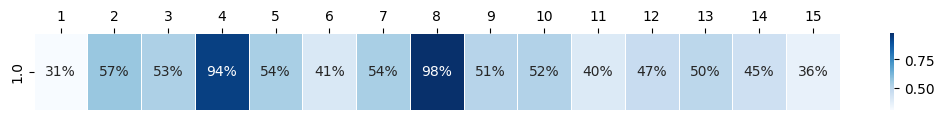

In [19]:
# 有6項政策無過半；9項過半
# 8 最高；1 最低
half_over = pd.DataFrame(counts.loc[1,:]).transpose() # 選index
plt.figure(figsize=(13,1))
sns.heatmap(half_over, cmap='Blues', annot=True, fmt="2.0%", linewidths=0.5)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.show()

In [20]:
# 檢視各議題支持度(排序:抓出超過5成的、最高、最低)
# summary  = df.describe()
# df_rank = pd.concat([ summary.columns.to_series(), summary.loc['mean']], axis=1).sort_values(by=['mean'], ascending=False)
# df_rank 
# 有6項政策無過半；9項過半
# 8 最高；1 最低

In [21]:
# 有無黨派對某項議題支持度高
agg_dict_2 = {
    '1':'mean',
    '2':'mean',
    '3':'mean',
    '4':'mean',
    '5':'mean',
    '6':'mean',
    '7':'mean',
    '8':'mean',
    '9':'mean',
    '10':'mean',
    '11':'mean',
    '12':'mean',
    '13':'mean',
    '14':'mean',
    '15':'mean'
}
party_support = df_new.groupby(['party']).agg(agg_dict_2).reset_index()
party_support

,party,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,D,0.704545,0.079545,0.011364,0.988636,0.011364,0.875000,0.079545,0.988636,0.034091,0.034091,0.852273,0.988636,0.034091,0.897727,0.784091
1,I,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
2,R,0.009259,1.000000,0.981481,0.907407,1.000000,0.018519,0.944444,0.981481,0.944444,0.981481,0.027778,0.046296,0.916667,0.083333,0.009259


In [22]:
# 定義一個函式，用於將數值轉換為著色格式
def colorize(value):
    if value < 0.5:
        return 'background-color: green'
    elif value > 0.5:
        return 'background-color: red'
    else:
        return ''

styled_df = party_support.iloc[:, 1:].style.applymap(colorize)
styled_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.704545,0.079545,0.011364,0.988636,0.011364,0.875000,0.079545,0.988636,0.034091,0.034091,0.852273,0.988636,0.034091,0.897727,0.784091
1,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
2,0.009259,1.000000,0.981481,0.907407,1.000000,0.018519,0.944444,0.981481,0.944444,0.981481,0.027778,0.046296,0.916667,0.083333,0.009259


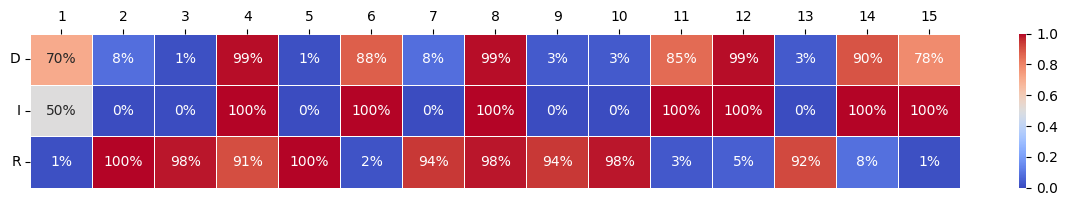

In [23]:
# 獨立派的政策選擇較一致(除了第一項措施)，且跟民主派的政策支持非常像(著色)
# 政策4、8 是所有黨派都支持的政策
# 1.6.11.12.14.15 民主黨較為支持，剩下的即為共和黨支持政策
# 哪個黨派比較團結? R黨亦即共和黨議員對各項政策支持方向較為一致，9成共和黨議員對各項政策的支持方向一致，較為團結。(獨立檔僅有2人，樣本太少較無法判斷)
plt.figure(figsize=(15,2))
sns.heatmap(party_support.iloc[:, 1:], cmap='coolwarm', annot=True, fmt="2.0%", linewidths=0.5)
plt.yticks(ticks=[i+0.5 for i in range(len(party_support['party']))], labels=party_support['party'], rotation='horizontal')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.show()

In [24]:
# 判斷哪些州的支持項目選擇相似(是否與黨派有關)
df_new.sort_values(by='state', inplace=True)
df_new.iloc[:, 3:18]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
88,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
65,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
86,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
84,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
24,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
13,0.5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
56,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [25]:
dis=sch.linkage(df_new.iloc[:, 3:18],metric='euclidean',method='ward')
dis.shape

(99, 4)

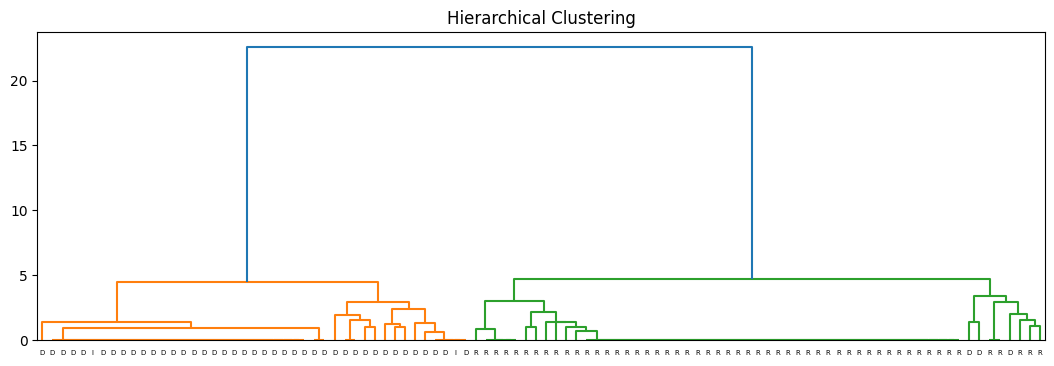

In [26]:
# 項目支持分群 與 政黨(議員) 關係
# 分群結果與上個分析結果一致，獨立派與民主黨支持的項目較相像；共和黨較為團結支持項目類似，民主黨有少部分人選擇跟共和黨相似，相對不團結 (獨立黨樣本過少較無法評論)
plt.figure(figsize=(13,4))
sch.dendrogram(dis, labels=df_new['party'].values)
plt.title('Hierarchical Clustering')
plt.xticks(rotation=0)
plt.show()

In [27]:
# 項目支持分群 與 州 關係
# plt.figure(figsize=(16,4))
# sch.dendrogram(dis, labels=df_new['state'].values)
# plt.title('Hierarchical Clustering')
# plt.xticks(rotation=0)
# plt.show()

In [28]:
order = sch.leaves_list(dis)
sorted_data = df_new.iloc[order, 1:18]
sorted_data

,party,state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
68,D,FL,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
67,D,WA,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
12,D,WA,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
54,D,VT,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
74,D,NV,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
51,R,IL,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
78,R,FL,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5


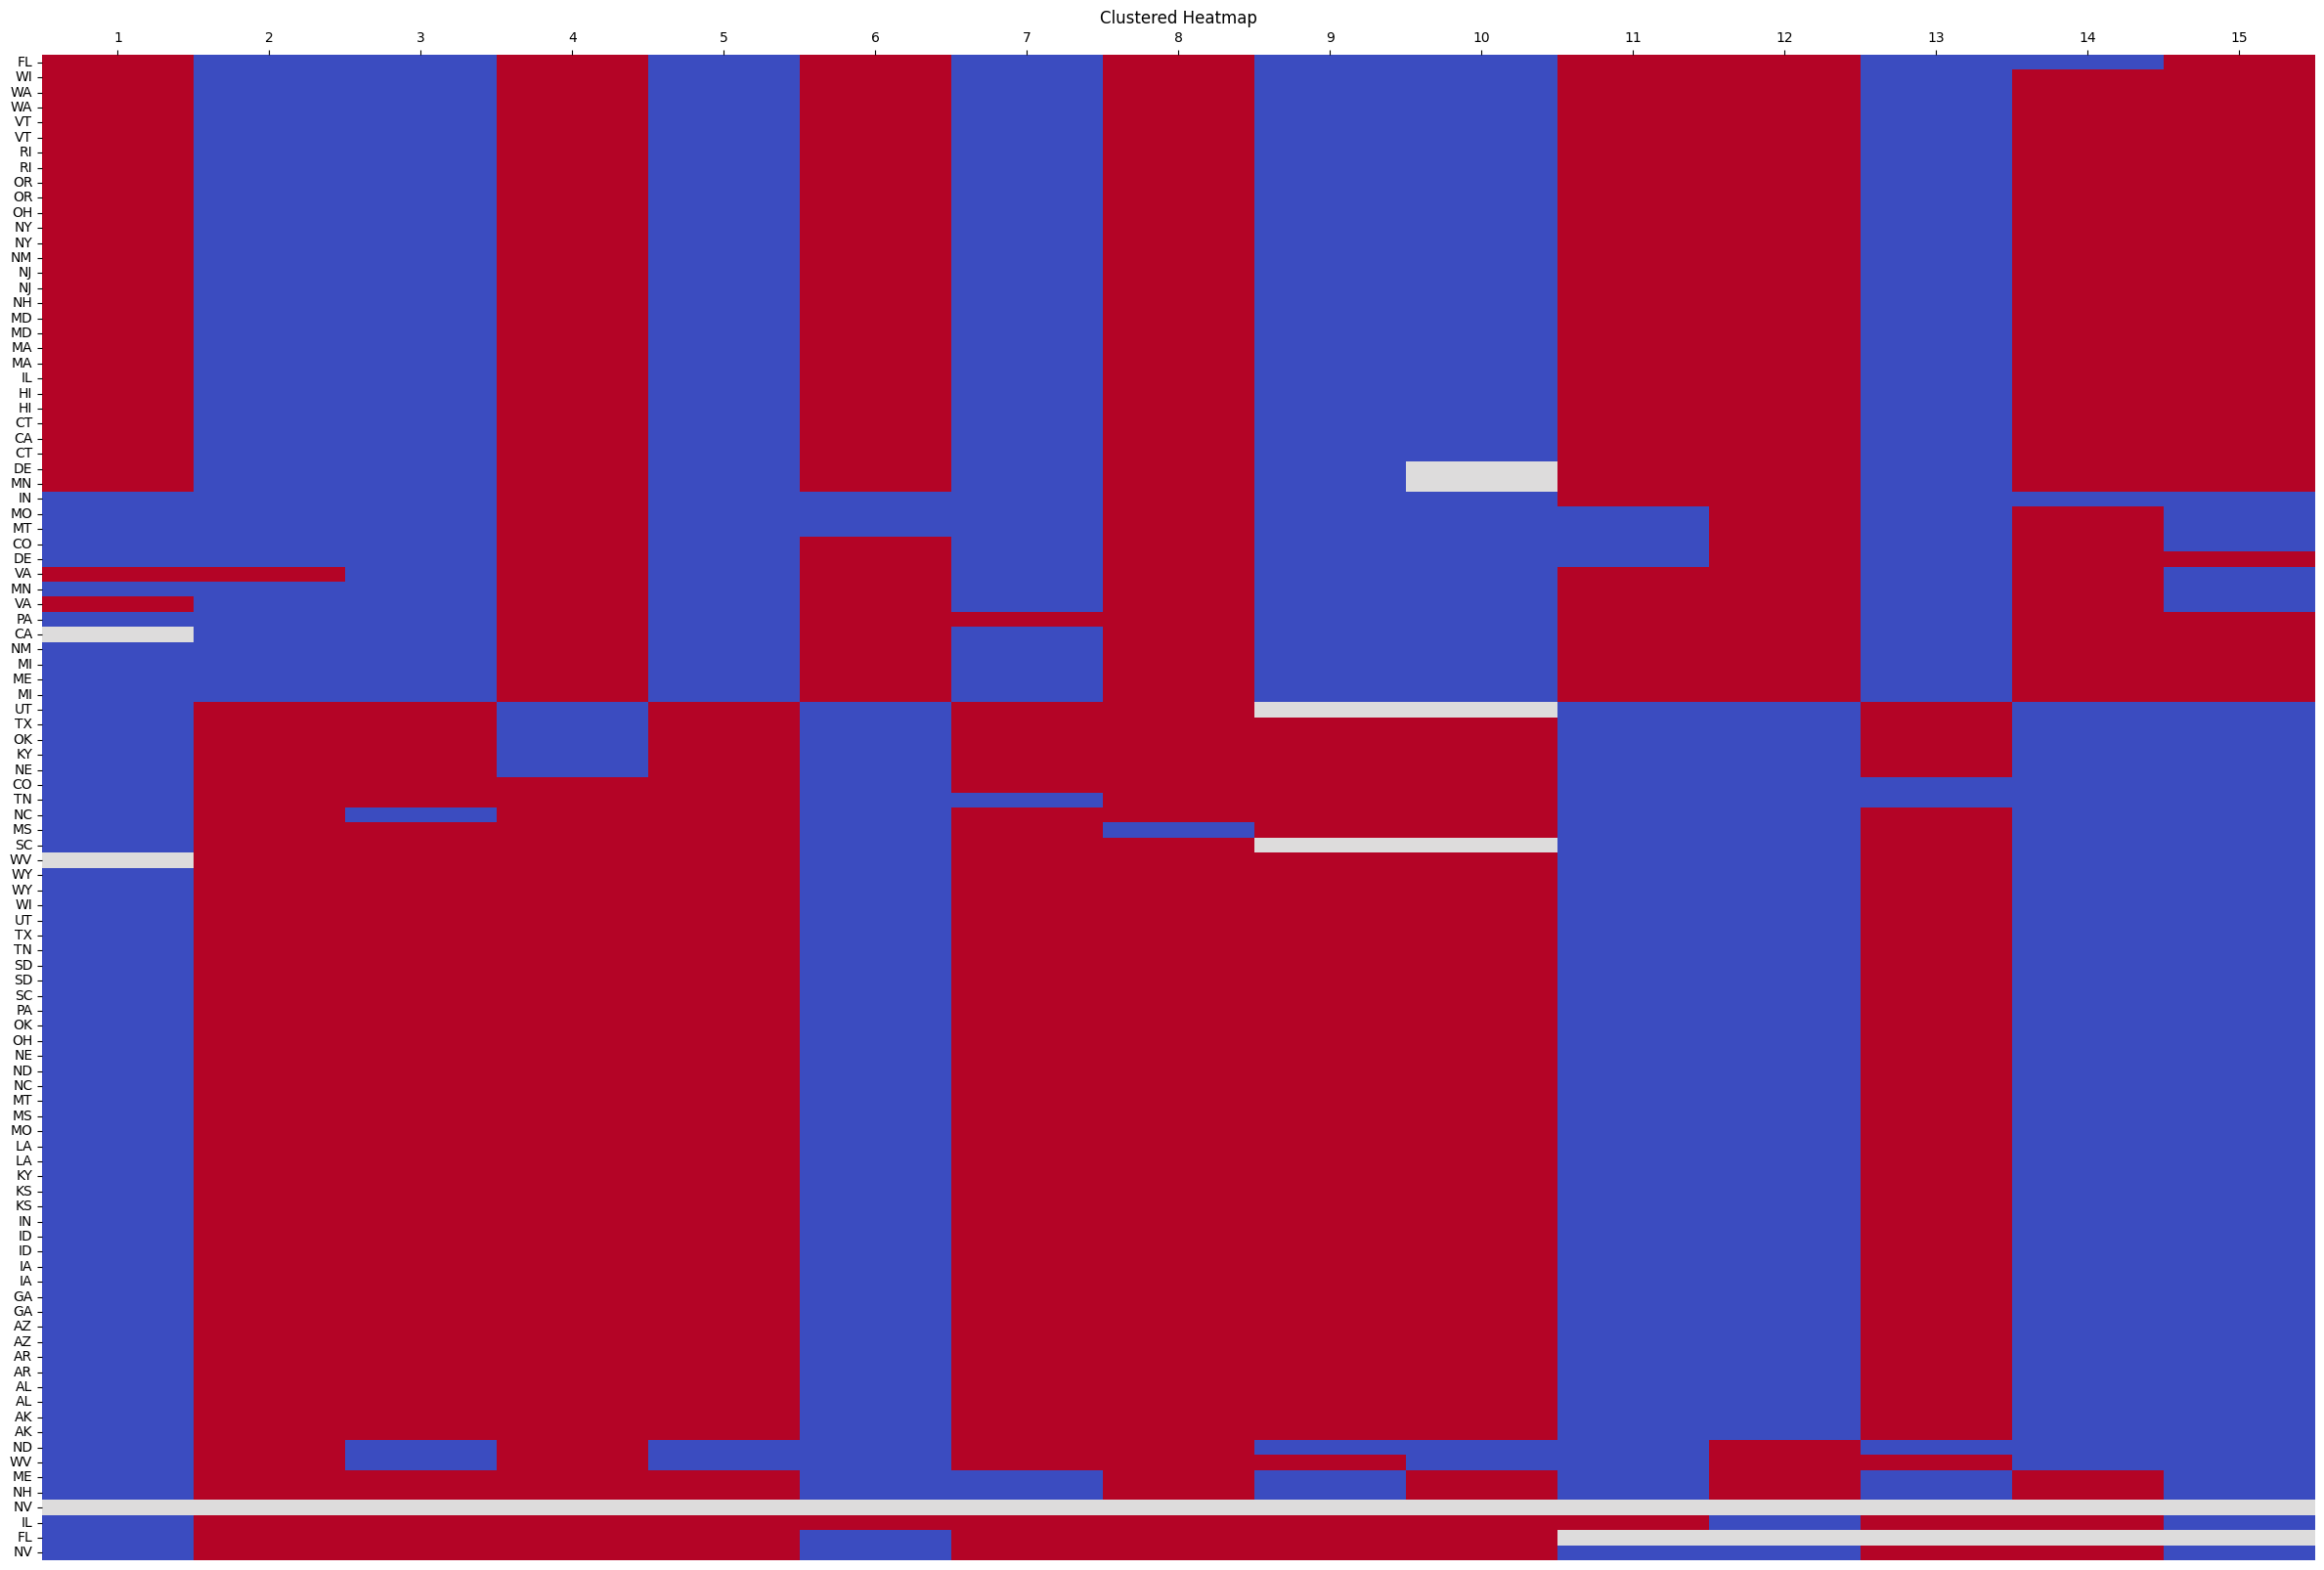

In [29]:
plt.figure(figsize=(30, 20))
sns.heatmap(sorted_data.iloc[:,2:], cmap='coolwarm', cbar=False)

plt.title('Clustered Heatmap')
plt.yticks(ticks=[i+0.5 for i in range(len(sorted_data['state']))], labels=sorted_data['state'], rotation='horizontal')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.show()

In [30]:
# 根據上圖大致可看出4個分群結果，可將議員分成4群 
threshold = 4  
clusters = fcluster(dis, threshold, criterion='distance')
clusters

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 3, 1, 1, 2, 1, 1, 4, 3, 3, 1, 1,
       3, 3, 3, 3, 4, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 2, 2, 2,
       1, 2, 3, 2, 3, 3, 3, 2, 3, 3, 4, 3, 3, 3, 1, 4, 1, 1, 1, 2, 4, 4,
       1, 1, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 1, 1, 1, 1, 3, 1, 3, 4, 3, 3], dtype=int32)

In [31]:
df_new['cluster'] = clusters
df_new

,name,party,state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,party_cnt,cluster
88,Sullivan,R,AK,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,3
65,Murkowski,R,AK,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,3
86,Shelby,R,AL,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,3
84,Sessions,R,AL,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,3
24,Cotton,R,AR,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2,1
13,Capito,R,WV,0.5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2,3
56,Manchin,D,WV,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2,4
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,3


In [33]:
# 檢視分群結果是否與政黨有關
pd.DataFrame(df_new.groupby(['cluster'])['party'].value_counts())

count
cluster party       
1       D         28
        I          1
2       D         13
        I          1
3       R         49
4       R          5
        D          3

In [ ]:
# 檢視各分群投票項目差異
agg_dict_4 = {
    '1':'mean',
    '2':'mean',
    '3':'mean',
    '4':'mean',
    '5':'mean',
    '6':'mean',
    '7':'mean',
    '8':'mean',
    '9':'mean',
    '10':'mean',
    '11':'mean',
    '12':'mean',
    '13':'mean',
    '14':'mean',
    '15':'mean'
}

cluster_people = df_new.groupby('cluster').agg(agg_dict_4).reset_index()
cluster_people

In [ ]:
plt.figure(figsize=(15,2))
sns.heatmap(cluster_people.iloc[:, 1:], cmap='coolwarm', annot=True, fmt="2.0%", linewidths=0.5)
plt.yticks(ticks=[i+0.5 for i in range(len(cluster_people['cluster']))], labels=cluster_people['cluster'], rotation='horizontal')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.show()

## GIS analysis

In [ ]:
us_states = gpd.read_file('C:\\Users\\專案企劃科專用\\Desktop\\python\\party\\dev\\data\\gis_shp\\tl_2019_us_state.shp')
cols = ['STUSPS', 'NAME', 'geometry']
us_states = us_states.loc[:, cols]
us_states.head(3)

In [ ]:
agg_dict_5 = {
    'party': ['nunique', lambda x : ','.join(x.to_list())],
    'cluster': ['nunique', lambda x : ','.join(x.astype(str).to_list())]
}
state_cluster_cnt = df_new.groupby('state').agg(agg_dict_5).reset_index()
state_cluster_cnt.columns = ['state', 'party_cnt', 'party', 'cluster_cnt', 'cluster']
state_cluster_cnt.head()

In [ ]:
duplicate = set(state_cluster_cnt.state) & set(us_states.STUSPS)
len(duplicate)

In [ ]:
merged_data = us_states.merge(state_cluster_cnt, left_on='STUSPS', right_on='state', how='inner')
merged_data.head()

In [ ]:
# 找到各州中心點，並標註州簡稱
centr = [shape(merged_data['geometry'][i]).centroid for i in range(len(merged_data))]
# centr[:5]
centr_data = gpd.GeoDataFrame(merged_data, geometry=centr, crs=4326)
centr_data.head

In [ ]:
display(gpd.GeoSeries(merged_data['geometry'][0]).to_json()[:100])

In [ ]:
f1 = folium.Figure(figsize=(15, 10))
m1 = folium.Map((39.653267, -100.218375), tiles='OpenStreetMap', zoom_start=4).add_to(f1)
# 畫上各州簡稱
for _, r in centr_data.iterrows():
    lon = r["geometry"].x
    lat = r["geometry"].y
    state_short_name = r["state"]
    folium.Marker(
        location=[lat, lon],
        icon=DivIcon(
            icon_size=(50,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 12pt; font-weight: bold;">{state_short_name}</div>'
        )
    ).add_to(m1)
# 兩個參議員皆來自共和黨
style_function_same_R= lambda x: {
    'fillColor': 'red', 
    'fillOpacity': 0.5,
    'color' : 'red',
    'weight' : 1
}
layer_party_same_R = folium.GeoJson(
    data=merged_data[(merged_data['party_cnt']==1) & (merged_data['party']=='R,R') ],
    name = '兩個參議員皆來自共和黨',
    style_function=style_function_same_R,
    show = False,
    popup=folium.GeoJsonPopup(
                   fields=['state', 'NAME', 'party_cnt', 'party'],
                   aliases = ['州簡稱', '周全稱', '政黨數量', '政黨名稱'],
                   style = "font-size: 18px", 
                   max_width=500)
).add_to(m1)
# 兩個參議員皆來自民主黨
style_function_same_D= lambda x: {
    'fillColor': 'blue', 
    'fillOpacity': 0.5,
    'color' : 'blue',
    'weight' : 1
}
layer_party_same_D = folium.GeoJson(
    data=merged_data[(merged_data['party_cnt']==1) & (merged_data['party']=='D,D') ],
    name = '兩個參議員皆來自民主黨',
    style_function=style_function_same_D,
    show = False,
    popup=folium.GeoJsonPopup(
                   fields=['state', 'NAME', 'party_cnt', 'party'],
                   aliases = ['州簡稱', '周全稱', '政黨數量', '政黨名稱'],
                   style = "font-size: 18px", 
                   max_width=500)
).add_to(m1)
# 兩個參議員不同政黨
style_function_diff= lambda x: {
    'fillColor': 'purple', 
    'fillOpacity': 0.5,
    'color' : 'purple',
    'weight' : 1
}
layer_party_diff = folium.GeoJson(
    data=merged_data[merged_data['party_cnt']==2],
    name = '兩個參議員不同政黨',
    style_function=style_function_diff,
    show = False,
    popup=folium.GeoJsonPopup(
                   fields=['state', 'NAME', 'party_cnt', 'party', 'cluster' ],
                   aliases = ['州簡稱', '周全稱', '政黨數量', '政黨名稱', '兩個議員投票分歧'],
                   style = "font-size: 18px", 
                   max_width=500)
).add_to(m1)
# 投票結果一致的州
style_function_same_c= lambda x: {
    'fillColor': 'green', 
    'fillOpacity': 0.5,
    'color' : 'green',
    'weight' : 1
}
layer_cluster_same = folium.GeoJson(
    data=merged_data[merged_data['cluster_cnt']==1],
    name = '投票結果一致的州',
    style_function=style_function_same_c,
    show = False,
    popup=folium.GeoJsonPopup(
                   fields=['state', 'NAME', 'party_cnt', 'party', 'cluster'],
                   aliases = ['州簡稱', '周全稱', '政黨數量', '政黨名稱', '投票分群'],
                   style = "font-size: 18px", 
                   max_width=500)
).add_to(m1)
# 投票結果分歧的州
style_function_diff_c= lambda x: {
    'fillColor': 'yellow', 
    'fillOpacity': 0.5,
    'color' : 'yellow',
    'weight' : 1
}
layer_cluster_same = folium.GeoJson(
    data=merged_data[merged_data['cluster_cnt']==2],
    name = '投票結果分歧的州',
    style_function=style_function_diff_c,
    show = False,
    popup=folium.GeoJsonPopup(
                   fields=['state', 'NAME', 'party_cnt', 'party', 'cluster'],
                   aliases = ['州簡稱', '周全稱', '政黨數量', '政黨名稱', '投票分群'],
                   style = "font-size: 18px", 
                   max_width=500)
).add_to(m1)

legend_html = """
<div style="position: fixed;
     bottom: 30px; right: 30px; width: 180px; height: 140px;
     background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px;
     ">
     <div style="background: red; opacity: 0.5; width: 20px; height: 20px; display: inline-block;"></div>
     <span style="vertical-align: middle;">參議員皆來自共和黨</span><br>
     <div style="background: blue; opacity: 0.5; width: 20px; height: 20px; display: inline-block;"></div>
     <span style="vertical-align: middle;">參議員皆來自民主黨</span><br>
     <div style="background: purple; opacity: 0.5; width: 20px; height: 20px; display: inline-block;"></div>
     <span style="vertical-align: middle;">參議員不同政黨</span><br>
     <div style="background: green; opacity: 0.5; width: 20px; height: 20px; display: inline-block;"></div>
     <span style="vertical-align: middle;">投票結果一致的州</span><br>
     <div style="background: yellow; opacity: 0.5; width: 20px; height: 20px; display: inline-block;"></div>
     <span style="vertical-align: middle;">投票結果分歧的州</span>
</div>
"""
m1.get_root().html.add_child(folium.Element(legend_html))
# 加入圖層管理器
folium.LayerControl().add_to(m1)
f1

In [ ]:
!jupyter nbconvert --embed-images  eda.ipynb --to html